# Ultimate Technologies data science challenge
### Jonas Cuadrado

## 1. Exploratory data analysis

The attached logins.json file contains (simulated) timestamps of user logins in a particular 
geographic location. Aggregate these login counts based on 15­ minute time intervals, and
visualize and describe the resulting time series of login counts in ways that best characterize the
underlying patterns of the demand. Please report/illustrate important features of the demand,
such as daily cycles. If there are data quality issues, please report them.

***
### Solution 1

First, load the data and take an inital look. Then, perform aggregations.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

lgidf = pd.read_json('logins.json')
lgidf.head()

In [2]:
lgidf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 93142 entries, 0 to 93141
Data columns (total 1 columns):
login_time    93142 non-null datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 1.4 MB


There are no nulls and everything is datetime, which means the data seems clean

In [3]:
lgidf.set_index('login_time', inplace=True)
lgidf['counts'] = 1
lgidf = lgidf.resample('15T').sum()

In [4]:
lgidf.head()

The data is aggregated now in 15-minute intervals. We want to look at cycles (such as weekday/weekend), daily cicles and correlations. Let's start by plotting the data

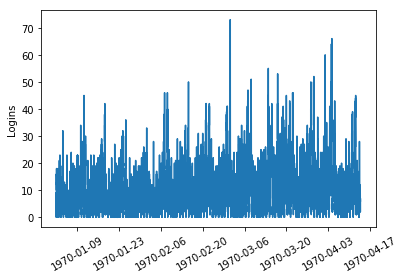

In [5]:
plt.plot(lgidf)
plt.xticks(rotation=30)
plt.ylabel('Logins')
plt.show()

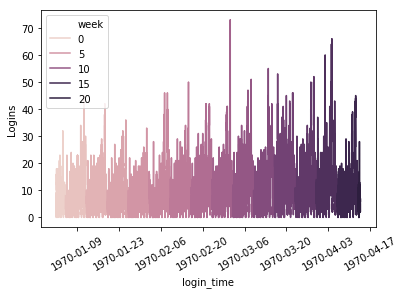

In [6]:
# I want to add a week label and plot some of them

lgidf['week'] = lgidf.index.week

sns.lineplot(data=lgidf.reset_index(), x ='login_time', y='counts', hue='week')
#plt.plot(lgidf[lgidf['week']==3])
plt.xticks(rotation=30)
plt.ylabel('Logins')
plt.show()


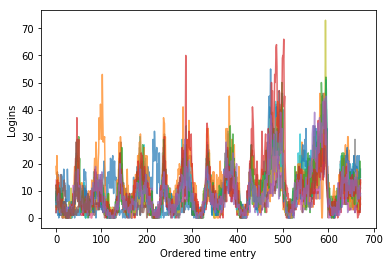

In [7]:
# tryna overlap the weeks to see variablity...
for i in range(min(lgidf.week),max(lgidf.week)+1):
    plt.plot(lgidf[lgidf['week']==i]['counts'].tolist(), alpha=0.7)
    

plt.ylabel('Logins')
plt.xlabel('Ordered time entry')
plt.show()

The cycles are rather consistent from week to week, with a possible increase on the weekends, and clear daily cycles to explore. Before looking at weekday vs weekend, let's try to reduce the data to a mean+std style to visualize it better...

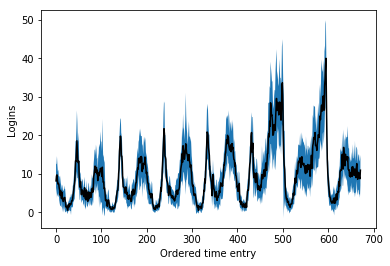

In [8]:
# drop 1st and last week because they are incomplete
aggdf=pd.DataFrame()
aggdf[2] = lgidf[lgidf['week']==2]['counts']
aggdf = aggdf.reset_index( drop=True)
for i in range(3,max(lgidf.week)):
    aggdf[i]=lgidf[lgidf['week']==i].reset_index()['counts']
    

meanstdwk = pd.DataFrame()
meanstdwk['mean']=aggdf.mean(axis=1)
meanstdwk['std']=aggdf.std(axis=1)

plt.plot(np.arange(len(meanstdwk['mean'])), meanstdwk['mean'], 'k-')
plt.fill_between(np.arange(len(meanstdwk['mean'])), meanstdwk['mean']-meanstdwk['std'], meanstdwk['mean']+meanstdwk['std'])
plt.ylabel('Logins')
plt.xlabel('Ordered time entry')
plt.show()

Here we can start to observe better the difference between weekday and weekend, and even intra-day cycles. Now, let me repeat this for specific days...

In [9]:
lgidf['dayofweek']=lgidf.index.dayofweek
lgidf.head()

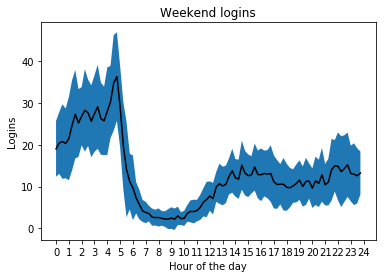

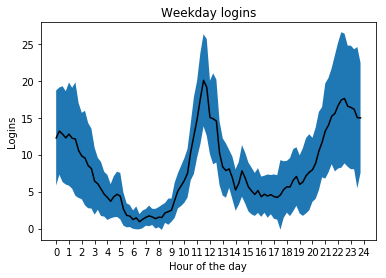

In [10]:
mfdf=pd.DataFrame()
auxdf = lgidf[lgidf['week']==1]
mfdf['w1d4'] = auxdf[auxdf['dayofweek']==4]['counts']
mfdf = mfdf.reset_index( drop=True)

ssdf=pd.DataFrame()
ssdf['w1d6'] = auxdf[auxdf['dayofweek']==6]['counts']
ssdf = ssdf.reset_index( drop=True)

for wk in range(2,max(lgidf.week)):
    auxdf = lgidf[lgidf['week']==wk]
    for day in range(7):
        if day<5:
            # it's a dayofweek, add to mfdf
            mfdf['w'+str(wk)+'d'+str(day)] = auxdf[auxdf['dayofweek']==day].reset_index()['counts']
        else:
            ssdf['w'+str(wk)+'d'+str(day)] = auxdf[auxdf['dayofweek']==day].reset_index()['counts']
# let's plot these now

meanstdss = pd.DataFrame()
meanstdss['mean']=ssdf.mean(axis=1)
meanstdss['std']=ssdf.std(axis=1)

plt.plot(np.arange(len(meanstdss['mean'])), meanstdss['mean'], 'k-')
plt.fill_between(np.arange(len(meanstdss['mean'])), meanstdss['mean']-meanstdss['std'], meanstdss['mean']+meanstdss['std'])
plt.ylabel('Logins')
plt.xlabel('Hour of the day')
plt.title('Weekend logins')
plt.xticks(np.arange(97, step=4), np.arange(0,25))
plt.show()

meanstdmf = pd.DataFrame()
meanstdmf['mean']=mfdf.mean(axis=1)
meanstdmf['std']=mfdf.std(axis=1)

plt.plot(np.arange(len(meanstdmf['mean'])), meanstdmf['mean'], 'k-')
plt.fill_between(np.arange(len(meanstdmf['mean'])), meanstdmf['mean']-meanstdmf['std'], meanstdmf['mean']+meanstdmf['std'])
plt.ylabel('Logins')
plt.xlabel('Hour of the day')
plt.title('Weekday logins')
plt.xticks(np.arange(97, step=4), np.arange(0,25))
plt.show()

In [11]:
print('Weekday mean aggregate', meanstdmf['mean'].sum())
print('Weekend day mean aggregate', meanstdss['mean'].sum())

Weekday mean aggregate 775.9295774647888
Weekend day mean aggregate 1267.2758620689656


We observe a sbstantial difference between weekdays and weekends. Monday to Friday people log in either at night or around lunch time, with two clear lows during the morning and afternoon. On the weekends there is more traffic on the afternoon than on the morning, but most of the logins occur at night, after midnight. In absolute values, weekends observe more logins than weekends at their peaks and on average.

The error bars describe a very solid trend within the data we have, with oscillations between months. We would need longer datasets to describe monthly or seasonal oscillations.

***
## 2. Experiment and metrics design

The neighboring cities of Gotham and Metropolis have complementary circadian rhythms: on
weekdays, Ultimate Gotham is most active at night, and Ultimate Metropolis is most active
during the day. On weekends, there is reasonable activity in both cities.

However, a toll bridge, with a two way toll, between the two cities causes driver partners to tend
to be exclusive to each city. The Ultimate managers of city operations for the two cities have
proposed an experiment to encourage driver partners to be available in both cities, by
reimbursing all toll costs.
* What would you choose as the key measure of success of this experiment in encouraging driver partners to serve both cities, and why would you choose this metric?
* Describe a practical experiment you would design to compare the effectiveness of the proposed change in relation to the key measure of success. Please provide details on:

    * how you will implement the experiment
    * what statistical test(s) you will conduct to verify the significance of theobservation
    * how you would interpret the results and provide recommendations to the city operations team along with any caveats.
    
***
### Solution 2

* Measures of success

The two logical measures of success are: the number of trips across the bridge, or the time spent on each city by person.

With respect to the bridge trips, by removing the toll we should see an increase. As of now, there are very few trips across the bridge because people stay on their city most of the time. Removing the toll should change this. This is a simple measure that, just by counting, can give a measure of the impact of the measure. If, in addition, we can measure round trips and the time lag between each leg, for instance, by tracking license plates, we can win singificant insigth or the population trends.

If we are tracking drivers by GPS, we could easily count how much time each driver spends on each city. As of now, there is high polarization, with an almost 100%-0% per driver. If removing the toll tends to equalize the times, we should get closer to 50-50 (or even 70-30 could be meaningful).

An additional test could be to return the tolls to a select number of drivers, and track their changes against the rest. But that is not fair to the whole, so I would not encourage it.

* Practical experiment

First, we want to compare a new situation (no toll) with a base case (tolls), and we want to see if there is a difference in number of trips across the bridge (for instance). This is essentially an A/B test that happens at different times. The first thing to do is collect data with tolls and quantify the number of trips. If there is seasonal variations, we should pick a time frame that is relevant: if we waive the tolls in July 2018, take data from July 2010 to 2017.

Then, implement the data and count the trips. If there are anough trips, a t-test should suffice to determine if there has been a change of not. For smaller datasets, we would use a z-test. The null hypothesis is that nothing changes, so, the number of trips through the bridge per day remains the same without toll. H1 is an increase of the number of trips. Defining a confidence level of 95% we could accept or reject the null hypothesis.

This also works with the time spent in each location as tracked by GPS.

We would require to track any other changes, for instance, if there are many more drivers than in the past, we would have to correct for how additional drivers may be forced to cross the bridge more often. Than can be taken from more recent data, say, June 2018.

In addition, the data could also tell if one city is preferred to the other, or what kind of activities each city is strongest at. This can be useful to improve the quality of live of the citizens and determine how to invest within each city.

## 3. Predictive modeling
Ultimate is interested in predicting rider retention. To help explore this question, we have
provided a sample dataset of a cohort of users who signed up for an Ultimate account inJanuary 2014. The data was pulled several months later; we consider a user retained if they
were “active” (i.e. took a trip) in the preceding 30 days.
We would like you to use this data set to help understand what factors are the best predictors
for retention, and offer suggestions to operationalize those insights to help Ultimate.
The data is in the attached file ultimate_data_challenge.json. See below for a detailed
description of the dataset. Please include any code you wrote for the analysis and delete the
dataset when you have finished with the challenge.
1. Perform any cleaning, exploratory analysis, and/or visualizations to use the provided data for this analysis (a few sentences/plots describing your approach will suffice). What fraction of the observed users were retained?
2. Build a predictive model to help Ultimate determine whether or not a user will be active in their 6th month on the system. Discuss why you chose your approach, what alternatives you considered, and any concerns you have. How valid is your model? Include any key indicators of model performance.
3. Briefly discuss how Ultimate might leverage the insights gained from the model to improve its long­ term rider retention (again, a few sentences will suffice).

### Data description
* city: city this user signed up in
* phone: primary device for this user
* signup_date: date of account registration; in the form ‘YYYY MM DD’
* last_trip_date: the last time this user completed a trip; in the form ‘YYYY MM DD’
* avg_dist: the average distance in miles per trip taken in the first 30 days after signup
* avg_rating_by_driver: the rider’s average rating over all of their trips
* avg_rating_of_driver: the rider’s average rating of their drivers over all of their trips
* surge_pct: the percent of trips taken with surge multiplier > 1
* avg_surge: The average surge multiplier over all of this user’s trips
* trips_in_first_30_days: the number of trips this user took in the first 30 days after signing up
* ultimate_black_user: TRUE if the user took an Ultimate Black in their first 30 days; FALSE otherwise
* weekday_pct: the percent of the user’s trips occurring during a weekday

***
### Solution 3



In [12]:
import json

file = open('ultimate_data_challenge.json', 'r')
df = pd.DataFrame(json.load(file))
file.close()

df.head()

In [13]:
df.describe()

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
avg_dist                  50000 non-null float64
avg_rating_by_driver      49799 non-null float64
avg_rating_of_driver      41878 non-null float64
avg_surge                 50000 non-null float64
city                      50000 non-null object
last_trip_date            50000 non-null object
phone                     49604 non-null object
signup_date               50000 non-null object
surge_pct                 50000 non-null float64
trips_in_first_30_days    50000 non-null int64
ultimate_black_user       50000 non-null bool
weekday_pct               50000 non-null float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


There is some data missing, for example, plenty of ratings are gone (ca.20%), and the dates are not on datetime format. If we simply drop those 20% we still have 40.000 elements to fit, which is enough for a classification system.

Let's look at a few distributions and time series...

In [15]:
df['last_trip_date']=pd.to_datetime(df['last_trip_date'])
df['signup_date']=pd.to_datetime(df['signup_date'])
df=df.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41445 entries, 0 to 49998
Data columns (total 12 columns):
avg_dist                  41445 non-null float64
avg_rating_by_driver      41445 non-null float64
avg_rating_of_driver      41445 non-null float64
avg_surge                 41445 non-null float64
city                      41445 non-null object
last_trip_date            41445 non-null datetime64[ns]
phone                     41445 non-null object
signup_date               41445 non-null datetime64[ns]
surge_pct                 41445 non-null float64
trips_in_first_30_days    41445 non-null int64
ultimate_black_user       41445 non-null bool
weekday_pct               41445 non-null float64
dtypes: bool(1), datetime64[ns](2), float64(6), int64(1), object(2)
memory usage: 3.8+ MB


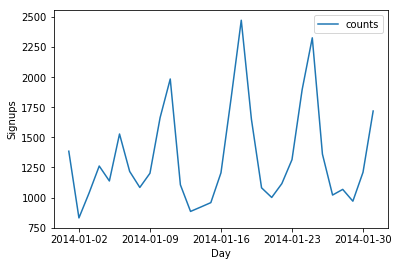

In [16]:
sudf = pd.DataFrame()
sudf['signup']=df['signup_date']
sudf.set_index('signup', inplace=True)
sudf['counts'] = 1
sudf = sudf.resample('1D').sum()
sns.lineplot(data=sudf)
plt.xlabel('Day')
plt.ylabel('Signups')
plt.show()

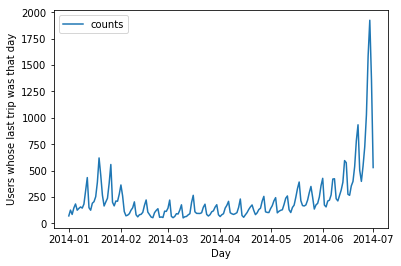

In [17]:
ltdf = pd.DataFrame()
ltdf['last']=df['last_trip_date']
ltdf.set_index('last', inplace=True)
ltdf['counts'] = 1
ltdf = ltdf.resample('1D').sum()
sns.lineplot(data=ltdf)
plt.xlabel('Day')
plt.ylabel('Users whose last trip was that day')
plt.show()

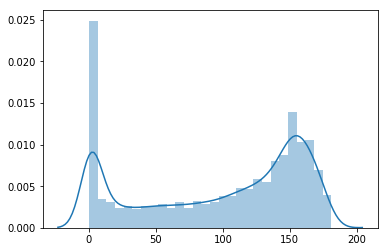

In [18]:
# time lapse to last trip
# we want to find the people with persistance >= 180 days!

persistancedf = pd.DataFrame()
persistancedf['persistance']=(df['last_trip_date']-df['signup_date']).dt.days

sns.distplot(persistancedf)
plt.show()

In [19]:
max(persistancedf['persistance'])

181

We barely have any data of users above the 6 month period, so technically is as if the data was unlabelled. I will generalized by saying that 5 months is a good enough indicator: people whose last trip is after 150 days of sign up are users after 6 months. We observe lots of dropouts at the very beginning, and a steady rate up to 100 days. We will use this to create the labels later on, before let me finish exploring the data

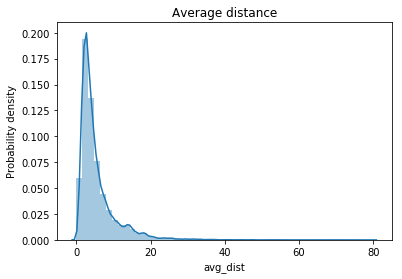

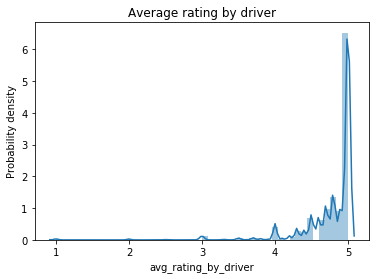

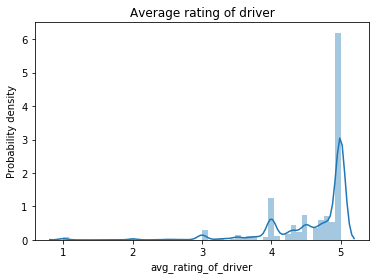

In [20]:
sns.distplot(df['avg_dist'])
plt.ylabel('Probability density')
plt.title('Average distance')
plt.show()

sns.distplot(df['avg_rating_by_driver'])
plt.ylabel('Probability density')
plt.title('Average rating by driver')
plt.show()

sns.distplot(df['avg_rating_of_driver'])
plt.ylabel('Probability density')
plt.title('Average rating of driver')
plt.show()

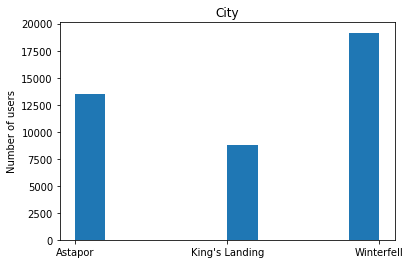

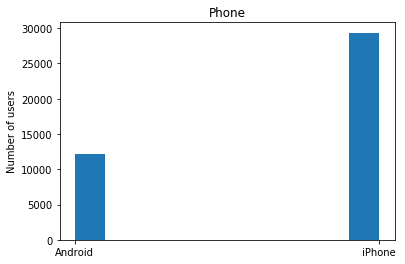

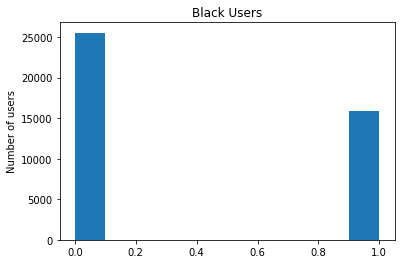

In [21]:
# bar plots of city, phone, ultimate_black_user
plt.hist(df['city'])
plt.ylabel('Number of users')
plt.title('City')
plt.show()

plt.hist(df['phone'])
plt.ylabel('Number of users')
plt.title('Phone')
plt.show()

plt.hist(df['ultimate_black_user'])
plt.ylabel('Number of users')
plt.title('Black Users')
plt.show()

It seems the data is rather will distributed, and most of the variables could be meaningful for prediction. Let's look at how to do predictions. I will use scikit-learn to classify the users as **active after 6 mos** or **inactive after 6 mos**, which is essentially like a spam filter. Provided we have less than 100.000 observations, we have plenty of options:

* Linear SVC: It's a support vector machine recommended for multiple labels. Here we have 2, but it should work well. We could also use stochastic gradient descend
* Naive Bayes: It's more adequate for discrete data. Some of our data is continuous, so this is not recommended
* KNN Classifier: If the data is clusterized, this could give the right communities. We are just looking for 2 clusters.
* Decision Tree: could perform well if the boundaries are not simple.

We need to encode the string variables such as city or phone.

We could also do regression to *when will the user abandon the service?*, where I would start with a Lasso or Ridge regressors.

The labels have not been created yet, I will do it as we go with previous results.

In [22]:
df['6m']=persistancedf['persistance']>=150
df = df.drop(columns=['last_trip_date','signup_date'])
df.head()

In [23]:
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.svm import LinearSVC


In [57]:
dfencoded = df.copy()

lecity = preprocessing.LabelEncoder()
lecity.fit(df['city'])
dfencoded['city']=lecity.transform(df['city'])

lephone = preprocessing.LabelEncoder()
lephone.fit(df['phone'])
dfencoded['phone']=lephone.transform(df['phone'])

dfencoded['ultimate_black_user'] = dfencoded['ultimate_black_user'].astype(int)
dfencoded.head()

In [59]:
X_train, X_test, y_train, y_test = train_test_split(dfencoded.drop(columns='6m'),dfencoded['6m'], test_size=0.2, random_state=42)
X_train = preprocessing.scale(X_train)
X_test = preprocessing.scale(X_test)


In [60]:
# plot confusion matrix as in 
# http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py

import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


SVC classifier results
Success rate: 0.7263843648208469
Normalized confusion matrix
[[0.971 0.029]
 [0.877 0.123]]


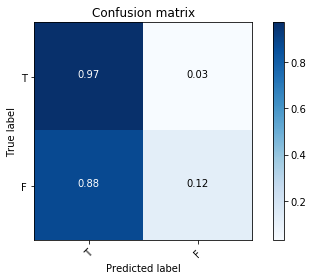

In [61]:
# let's start with linearsvc...
clf = LinearSVC(random_state=42, tol=1e-5)
clf.fit(X_train, y_train)
print('SVC classifier results')

print('Success rate:', sum(clf.predict(X_test) == y_test)/len(y_test))
cnf_matrix = confusion_matrix(y_test, clf.predict(X_test))

np.set_printoptions(precision=3)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['T','F'],normalize=True, title='Confusion matrix')

The linear SVM does not capture well those users who will not use the service in 6 months. It's not an adequate model

KNN classifier results
Success rate: 0.741585233441911
Normalized confusion matrix
[[0.851 0.149]
 [0.527 0.473]]


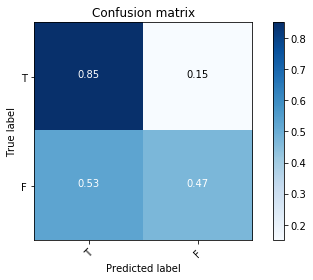

In [62]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier()
neigh.fit(X_train, y_train) 


print('KNN classifier results')

print('Success rate:', sum(neigh.predict(X_test) == y_test)/len(y_test))
cnf_matrix = confusion_matrix(y_test, neigh.predict(X_test))

np.set_printoptions(precision=3)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['T','F'],normalize=True, title='Confusion matrix')

About the same success rate, but captures better the dropoffs. We need to do better...

SVCrbf classifier results
Success rate: 0.762214983713355
Normalized confusion matrix
[[0.919 0.081]
 [0.624 0.376]]


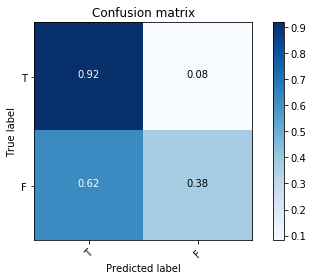

In [63]:
# try SVM with a polynomial line, and with 
from sklearn import svm

svcrbf = svm.SVC(kernel='rbf')
svcrbf.fit(X_train, y_train)
print('SVCrbf classifier results')

print('Success rate:', sum(svcrbf.predict(X_test) == y_test)/len(y_test))
cnf_matrix = confusion_matrix(y_test, svcrbf.predict(X_test))
np.set_printoptions(precision=3)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['T','F'],normalize=True, title='Confusion matrix')

Decision Tree Classifier results
Success rate: 0.691398238629509
Normalized confusion matrix
[[0.782 0.218]
 [0.531 0.469]]


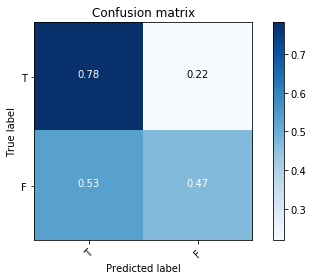

In [64]:
from sklearn.tree import DecisionTreeClassifier

dtc = DecisionTreeClassifier()
dtc.fit(X_train, y_train)
print('Decision Tree Classifier results')

print('Success rate:', sum(dtc.predict(X_test) == y_test)/len(y_test))
cnf_matrix = confusion_matrix(y_test, dtc.predict(X_test))
np.set_printoptions(precision=3)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['T','F'],normalize=True, title='Confusion matrix')

Given the results, it seems that the most accurate model is the KNN. In order to improve it we could use a gridsearchCV to find the optimal values. However, the want that predicts best the abandonments is the last one, the random tree.

Let's look at the most meaningful parameters: that will tell the company where to focus on the effort to retain customers more.

In [67]:
fi = pd.DataFrame(dtc.feature_importances_).T
fi.columns = list(dfencoded.drop(columns='6m').columns)
fi

The most meaningful features are the average distance, weekday percentage, and average rating by driver.

In [51]:
df[df['6m']==True].sort_values(by='avg_dist', ascending=False).head(25)

In [52]:
df[df['6m']==True].sort_values(by='weekday_pct', ascending=False).head(25)

The company may want to focus onto these features to increase the retention. 
It seems longer ride users are more likely to stay

It may want to encourage longer or shorter rides, or give some price reduction in some cases. It may also want to improve the service to users that are not exclusive on weekdays. 
